# 1. Processing data

In [1]:
!ls

bank-classification.csv  mnist_cnn.ipynb    README.md		   setup.sh
experiments.ipynb	 my_submission.csv  requirements.txt
instructions.txt	 project_env	    sample_submission.csv


In [2]:
!head sample_submission.csv

id,y
2,0.114428578297
4,0.114428578297
5,0.114428578297
7,0.114428578297
10,0.114428578297
12,0.114428578297
14,0.114428578297
16,0.114428578297
18,0.114428578297


In [3]:
import pandas as pd
df = pd.read_csv('bank-classification.csv')
# It's important to shuffle the data
df = df.sample(frac=1, replace=False, random_state=42)
print(df[:5])

          id  birth_date          job  marital    education  default housing  \
32884  32885  1952-07-15   technician  married  high.school       no      no   
3169    3170  1953-06-30      unknown  married      unknown  unknown     yes   
32206  32207  1976-09-12  blue-collar  married     basic.9y       no      no   
9403    9404  1972-04-10       admin.  married  high.school       no      no   
14020  14021  1981-05-25    housemaid  married  high.school       no     yes   

      loan contact_date    contact  campaign  pdays  previous     poutcome  \
32884  yes   2009-05-04   cellular         1    999         1      failure   
3169    no   2008-05-08  telephone         2    999         0  nonexistent   
32206   no   2009-05-08   cellular         1    999         1      failure   
9403    no   2008-06-27  telephone         4    999         0  nonexistent   
14020   no   2008-07-25   cellular         2    999         0  nonexistent   

             y  
32884  unknown  
3169   unknown  

### Let's split training and test sets.

In [4]:
train_df = df.loc[df['y'] != 'unknown']
test_df = df.loc[df['y'] == 'unknown']

In [5]:
train_df.loc[:, 'y'] = train_df.loc[:, 'y'].map({'no': 0, 'yes': 1})

/home/michal/Pulpit/jnp_ml/banking_predictions/project_env/lib/python3.5/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


#### Let's make sure it works despite warning

In [6]:
train_df['y'][:5]

32206    0
9403     0
17201    0
23757    0
16735    0
Name: y, dtype: int64

# 2. Features analysis

### Let's examine the proportion of yes/no labels in training set

In [7]:
pd.value_counts(train_df.y)

0    18419
1     2380
Name: y, dtype: int64

In [8]:
def get_year(date):
    year_str = date[:4]
    year = int(year_str)
    return year

def get_month(date):
    month_str = date[5:7]
    month = int(month_str)
    return month

def get_year_and_month(date):
    return get_year(date), get_month(date)

import datetime

def get_weekday(date_str):
    year, month, day = [int(item) for item in date_str.split('-')]
    return datetime.datetime(year, month, day).weekday()

### Dates analysis

In [9]:
months = train_df['contact_date'].map(get_month)
years = train_df['contact_date'].map(get_year)
weekday = train_df['contact_date'].map(get_weekday)
year_month = train_df['contact_date'].map(get_year_and_month)
birth = train_df['birth_date'].map(get_year)
ages = years - birth

date_df = pd.DataFrame({
    'months' : months,
    'years' : years,
    'weekday': weekday,
    'ages': ages,
    'year_month': year_month,
    'y': train_df['y']
})

In [10]:
print(date_df[:5])

       ages  months  weekday  y year_month  years
32206    33       5        4  0  (2009, 5)   2009
9403     36       6        4  0  (2008, 6)   2008
17201    58       7        4  0  (2008, 7)   2008
23757    51       8        3  0  (2008, 8)   2008
16735    58       7        3  0  (2008, 7)   2008


### Months and years vary in terms of number of calls and succesful contacts. Let's add feature (month, year) as well.

In [11]:
import matplotlib.pyplot as plt
months = date_df.get(['y', 'months']).groupby(['months']).mean()
months.plot(kind='bar', figsize=(15, 4))
plt.show()
pd.value_counts(date_df.months).plot(kind='bar', figsize=(15, 5))
plt.show()

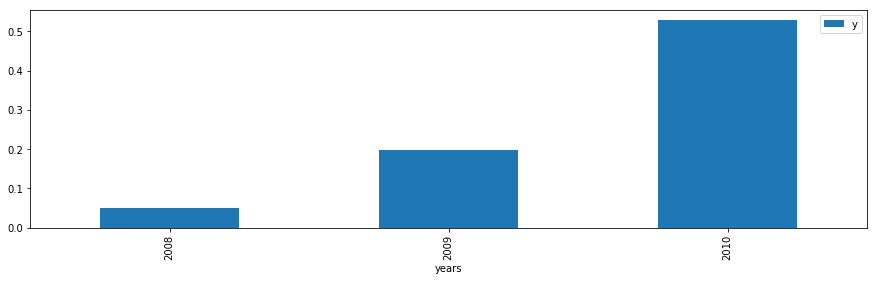

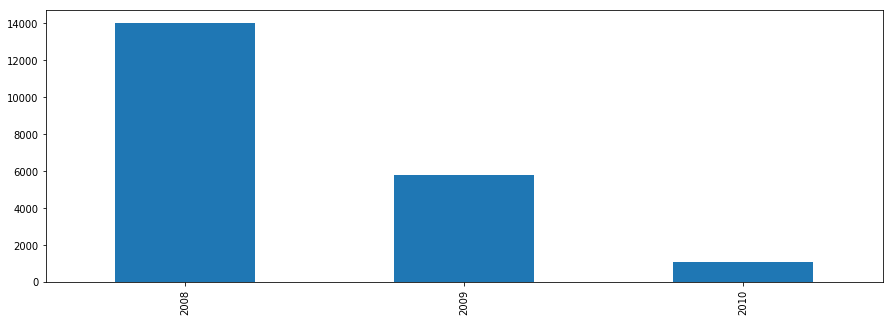

In [12]:
months = date_df.get(['y', 'years']).groupby(['years']).mean()
months.plot(kind='bar', figsize=(15, 4))
plt.show()
pd.value_counts(date_df.years).plot(kind='bar', figsize=(15, 5))
plt.show()

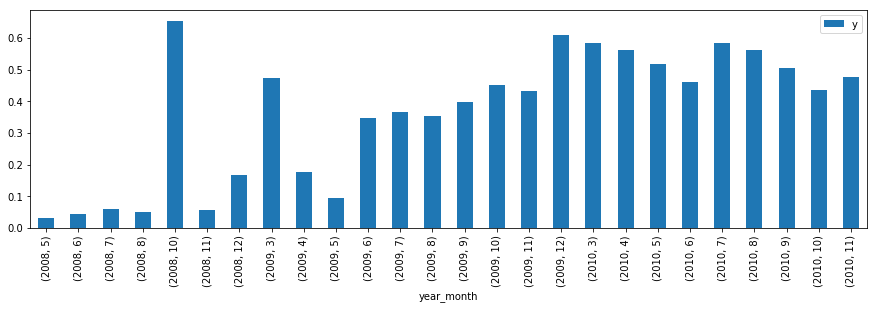

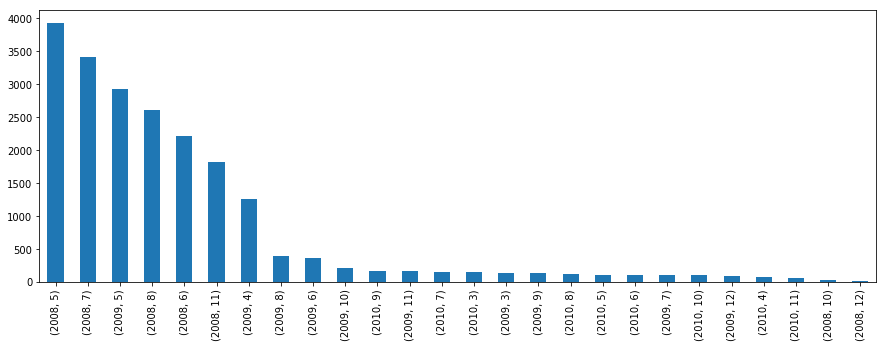

In [13]:
months = date_df.get(['y', 'year_month']).groupby(['year_month']).mean()
months.plot(kind='bar', figsize=(15, 4))
plt.show()
pd.value_counts(date_df.year_month).plot(kind='bar', figsize=(15, 5))
plt.show()

### Apparently calls in the middle of the week are a bit more succesful 

                y
weekday          
0        0.098438
1        0.110037
2        0.123719
3        0.126951
4        0.112365


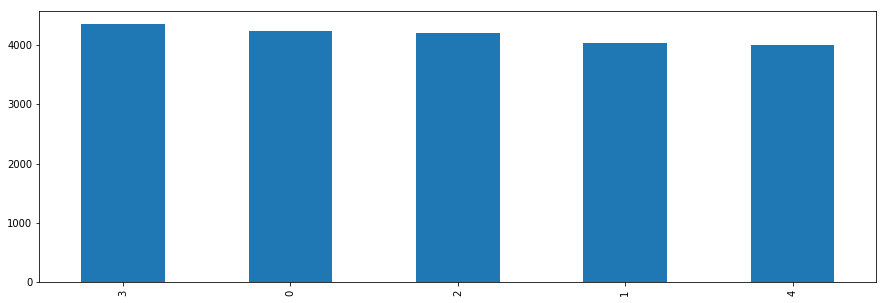

In [14]:
months = date_df.get(['y', 'weekday']).groupby(['weekday']).mean()
print(months)
pd.value_counts(date_df.weekday).plot(kind='bar', figsize=(15, 5))
plt.show()

### Let's divide age into groups

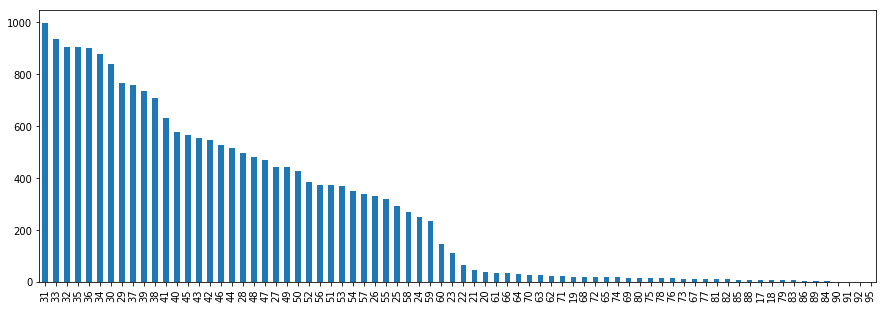

In [15]:
pd.value_counts(date_df.ages, sort=True).plot(kind='bar', figsize=(15, 5))
plt.show()

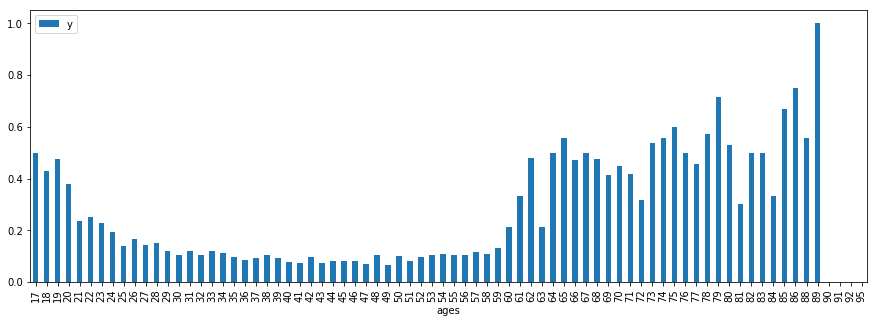

In [16]:
age_means = date_df.get(['y', 'ages']).groupby(['ages']).mean()
age_means.plot(kind='bar', figsize=(15, 5))
plt.show()

### Let's look at the job distribution and the probabilities.

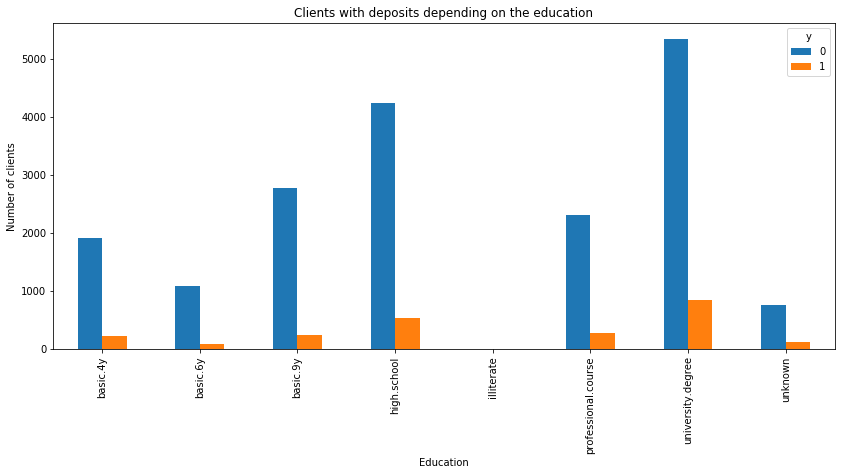

In [17]:
pd.crosstab(train_df.education, train_df.y).plot(kind='bar', figsize=(14, 6))
plt.title('Clients with deposits depending on the education')
plt.xlabel('Education')
plt.ylabel('Number of clients')
plt.show()

### Let's check if the distributions are equal on train and test sets

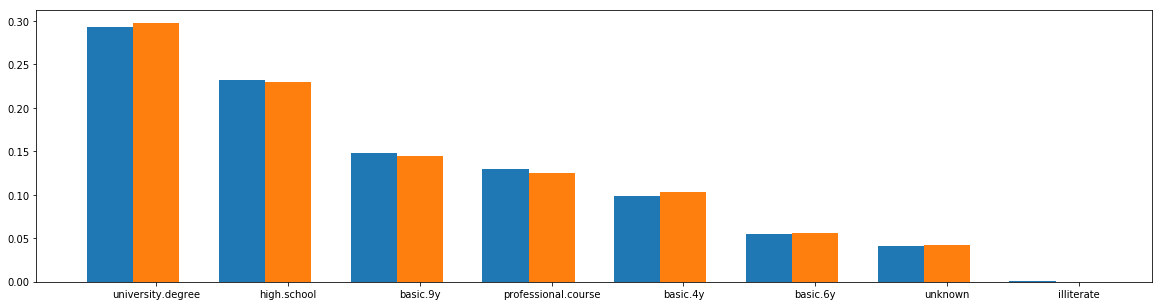

In [18]:
import numpy as np
education_test = pd.value_counts(test_df.education) / len(test_df)
education_train = pd.value_counts(train_df.education) / len(train_df)
plt.figure(figsize=(20, 5))
bar_width = 0.35
n_groups = len(education_test.keys())
index = np.arange(n_groups)
plt.bar(index, education_test, bar_width)
plt.bar(index + bar_width, education_train, bar_width)
plt.xticks(index + bar_width, education_test.keys())
plt.show()

### Let's examine the medium chance of a deposit subscription regarding the education.

In [19]:
education_means = train_df.get(['education', 'y']).groupby(['education']).mean()
print(education_means)

                            y
education                    
basic.4y             0.109099
basic.6y             0.076068
basic.9y             0.082891
high.school          0.112738
illiterate           0.142857
professional.course  0.110340
university.degree    0.137435
unknown              0.145434


### Let's examine the same for profession.

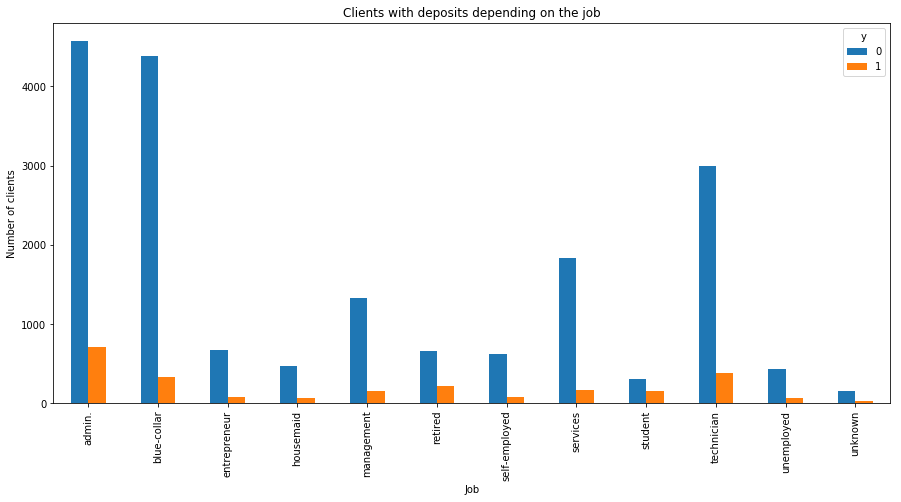

In [20]:
pd.crosstab(train_df.job, train_df.y).plot(kind='bar', figsize=(15, 7))
plt.title('Clients with deposits depending on the job')
plt.xlabel('Job')
plt.ylabel('Number of clients')
plt.show()

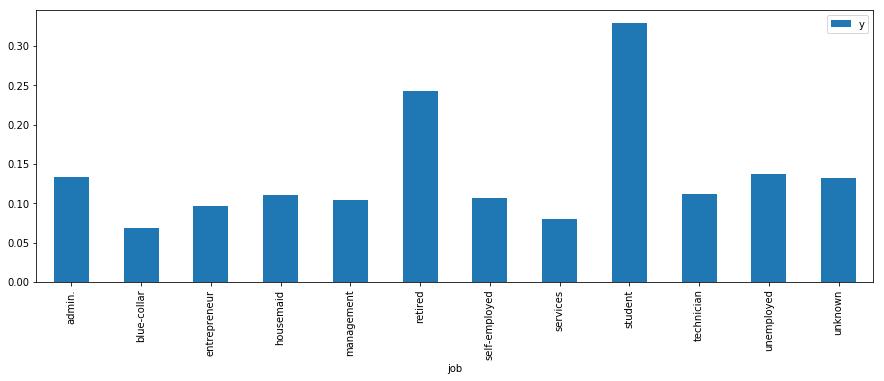

In [21]:
job_means = train_df.get(['job', 'y']).groupby(['job']).mean()
job_means.plot(kind='bar', figsize=(15, 5))
plt.show()

### Analysis for marital status

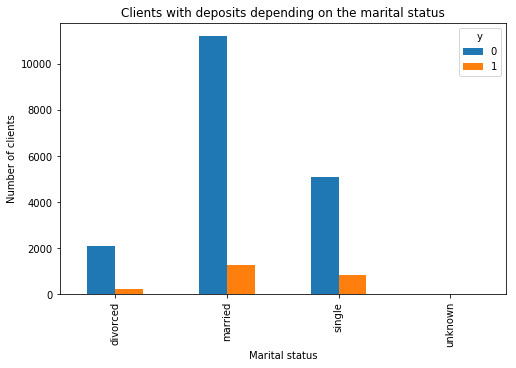

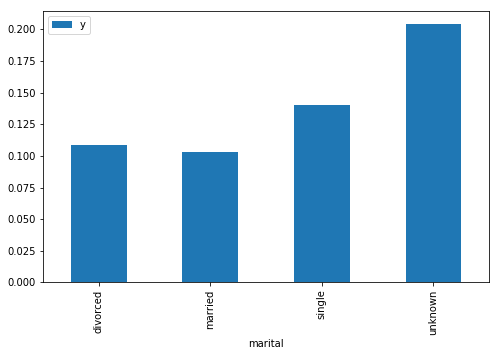

In [22]:
pd.crosstab(train_df.marital, train_df.y).plot(kind='bar', figsize=(8, 5))
plt.title('Clients with deposits depending on the marital status')
plt.xlabel('Marital status')
plt.ylabel('Number of clients')
marital_means = train_df.get(['marital', 'y']).groupby(['marital']).mean()
marital_means.plot(kind='bar', figsize=(8, 5))
plt.show()

### Let's have a look at the number of calls in the previous campaign

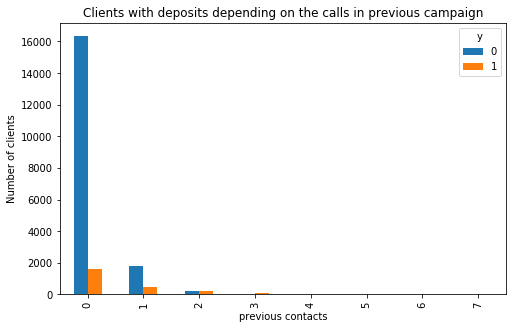

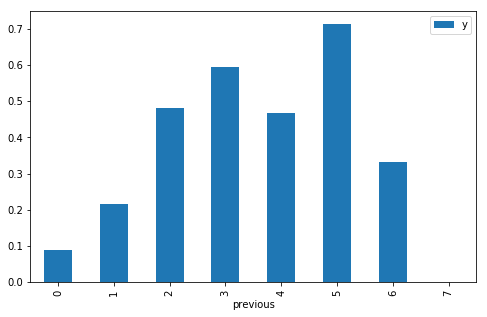

In [23]:
previous_mean = train_df.get(['previous', 'y']).groupby(['previous']).mean()
pd.crosstab(train_df.previous, train_df.y).plot(kind='bar', figsize=(8, 5))
plt.title('Clients with deposits depending on the calls in previous campaign')
plt.xlabel('previous contacts')
plt.ylabel('Number of clients')
previous_means = train_df.get(['previous', 'y']).groupby(['previous']).mean()
previous_means.plot(kind='bar', figsize=(8, 5))
plt.show()

### Outcome of the previous campaign - another important factor

In [24]:
print(pd.value_counts(train_df.poutcome))
print(train_df.get(['poutcome', 'y']).groupby(['poutcome']).mean())

nonexistent    17983
failure         2143
success          673
Name: poutcome, dtype: int64
                    y
poutcome             
failure      0.151190
nonexistent  0.089807
success      0.655275


### Number of contacts in this campaign - let's divide into bins

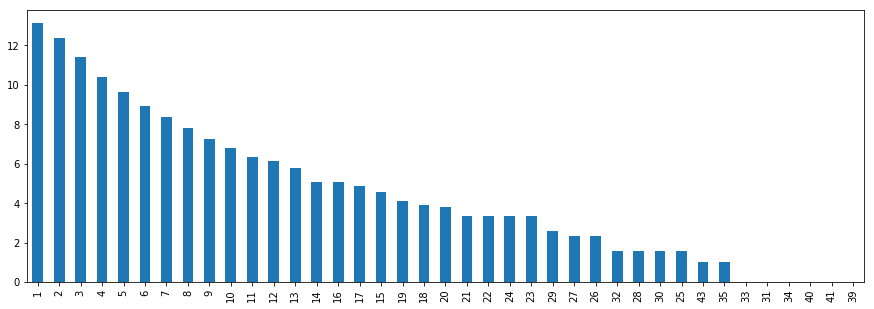

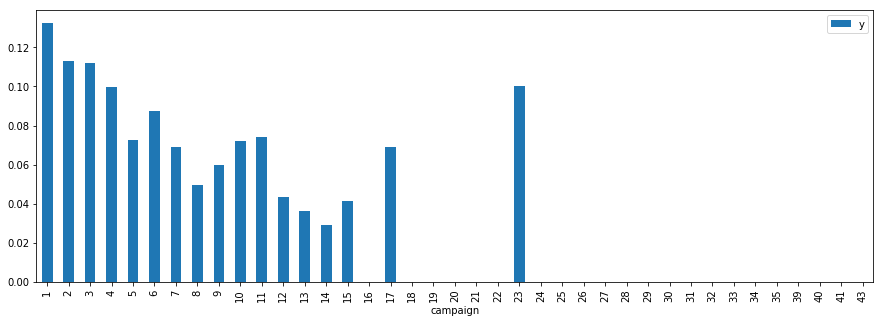

In [25]:
campaing_calls = np.log2(pd.value_counts(train_df.campaign))
campaing_calls.plot(kind='bar', figsize=(15, 5))
plt.show()
calls_mean = train_df.get(['y', 'campaign']).groupby(['campaign']).mean()
calls_mean.plot(kind='bar', figsize=(15, 5))
plt.show()

### Type of contact is significantly correlated with the final decision.

In [26]:
print(pd.value_counts(train_df.contact))
print(train_df.get(['y', 'contact']).groupby(['contact']).mean())

cellular     13212
telephone     7587
Name: contact, dtype: int64
                  y
contact            
cellular   0.149864
telephone  0.052722


### Now let's look at loan/housing - no major relation with the result

In [27]:
print(train_df.get(['housing', 'y']).groupby(['housing']).mean())
print(train_df.get(['loan', 'y']).groupby(['loan']).mean())

                y
housing          
no       0.109738
unknown  0.114286
yes      0.118466
                y
loan             
no       0.114531
unknown  0.114286
yes      0.113900


### Information about default is much more relevant 

In [28]:
print(pd.value_counts(train_df.default))
print(train_df.get(['default', 'y']).groupby(['default']).mean())

no         16408
unknown     4389
yes            2
Name: default, dtype: int64
                y
default          
no       0.130607
unknown  0.053999
yes      0.000000


### Number of days that passed by after the client was last contacted from a previous campaign - no significant trend only few groups

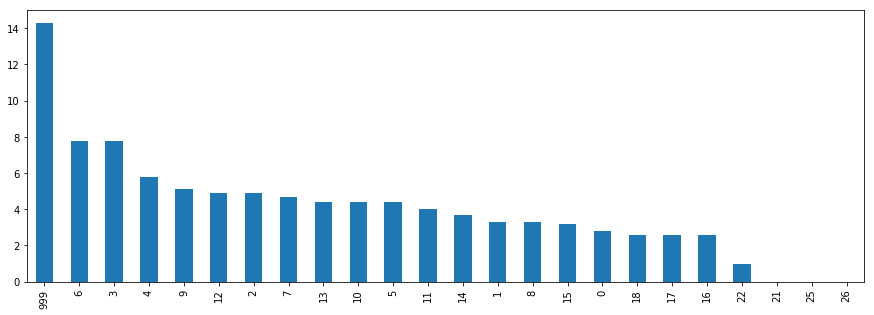

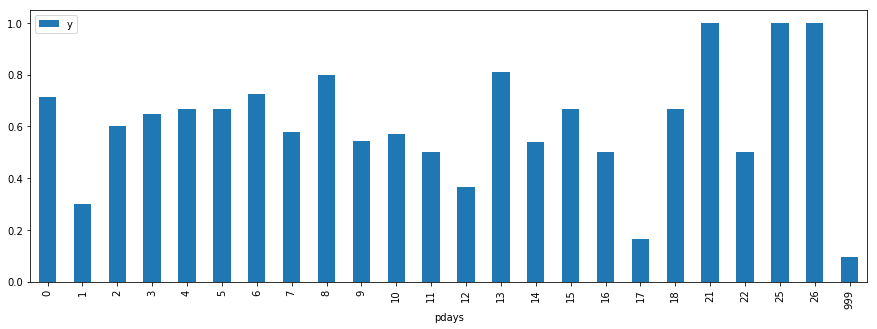

In [29]:
previous_days = np.log2(pd.value_counts(train_df.pdays))
previous_days.plot(kind='bar', figsize=(15, 5))
plt.show()
pdays_mean = train_df.get(['y', 'pdays']).groupby(['pdays']).mean()
pdays_mean.plot(kind='bar', figsize=(15, 5))
plt.show()

### Let's examine ids - clients with larget ids are more likely to get a term deposit

In [30]:
new_df = train_df.get(['id', 'y'])
new_df = new_df.sort_values('id')

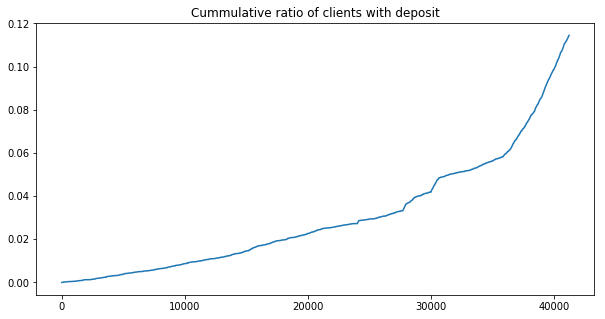

In [31]:
x = new_df['id']
y = np.cumsum(new_df['y']) / len(new_df)
plt.figure(figsize=(10, 5))
plt.plot(x, y)
plt.title('Cummulative ratio of clients with deposit')
plt.show()

### With id being independent on the results, we would have a linear function

# 3. Features extraction

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import LabelEncoder

def get_categorical(column):
    le = LabelEncoder()
    le.fit(column)
    labeled_column = le.transform(column)
    return to_categorical(labeled_column).T

def get_input_data(df):
    # groups 0-15 / 15-30 / ...
    ages = get_categorical([(get_year(contact) - get_year(birth)) // 10 for contact, birth in
                     zip(df['contact_date'], df['birth_date'])])
    
    jobs = get_categorical(df['job'])
    education = get_categorical(df['education'])
    marital = get_categorical(df['marital'])
    default = get_categorical(df['default'])
    loan = get_categorical(df['loan'])

    contact_years = [get_year(contact) - 2008 for contact in df['contact_date']]
    contact_months = get_categorical([get_month(contact) for contact in df['contact_date']])
    contact = get_categorical(contact_years)
    poutcome = get_categorical(df['poutcome'])
    previous = np.array([df['previous']])
    contact_type = np.array([df['contact'] == 'cellular'])
    id_num = np.array([df['id']])

    # divide into bins
    campaign = np.array([
        np.array(df['campaign'].isin(range(2)), dtype=int),
        np.array(df['campaign'].isin(range(2, 4)), dtype=int),
        np.array(df['campaign'].isin(range(4, 7)), dtype=int),
        np.array(df['campaign'].isin(range(7, 12)), dtype=int),
        np.array(df['campaign'].isin(range(12, 100)), dtype=int)

    ])
    
    pdays = np.array([np.array(df['pdays'] == 999, dtype=int),
                     np.array(df['pdays'] == 0, dtype=int),
                     np.array(df['pdays'].isin(range(1, 15)), dtype=int)])
            
    contact_weekday = get_categorical(np.array(df['contact_date'].map(get_weekday)))
    contact_combined_year_month = get_categorical(df['contact_date'].map(get_year_and_month))
    return np.concatenate([ages, jobs, education, marital, default, contact, poutcome,
                           campaign, previous, contact_type, pdays, contact_months, 
                           contact_weekday,
                           contact_combined_year_month,
                           id_num
                          ], axis=0).T, np.array(df['y'])

Using TensorFlow backend.


# 4. Model selection 

In [33]:
from xgboost import XGBClassifier

classifier = XGBClassifier(n_estimators=100, subsample=1.0, scale_pos_weight=1.)
X, y = get_input_data(train_df)
print(X, y)

/home/michal/Pulpit/jnp_ml/banking_predictions/project_env/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


[[  0.00000000e+00   0.00000000e+00   1.00000000e+00 ...,   0.00000000e+00
    0.00000000e+00   3.22070000e+04]
 [  0.00000000e+00   0.00000000e+00   1.00000000e+00 ...,   0.00000000e+00
    0.00000000e+00   9.40400000e+03]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00 ...,   0.00000000e+00
    0.00000000e+00   1.72020000e+04]
 ..., 
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00 ...,   0.00000000e+00
    0.00000000e+00   3.71950000e+04]
 [  0.00000000e+00   0.00000000e+00   1.00000000e+00 ...,   0.00000000e+00
    0.00000000e+00   1.12850000e+04]
 [  0.00000000e+00   1.00000000e+00   0.00000000e+00 ...,   0.00000000e+00
    0.00000000e+00   1.57960000e+04]] [0 0 0 ..., 0 0 0]


No need for scaling - no numerical features

In [34]:
from sklearn.model_selection import GridSearchCV
parameters = {'n_estimators': [30, 60, 100], 'learning_rate': [0.05, 0.1, 0.15], 'min_child_weight': [1, 2],
             'gamma': [0., 0.05]}
grid_classifier = GridSearchCV(classifier, parameters, scoring='roc_auc', cv=8, n_jobs=1, verbose=10)

In [35]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score, make_scorer, accuracy_score
grid_classifier.fit(X, y)

Fitting 8 folds for each of 36 candidates, totalling 288 fits
[CV] n_estimators=30, gamma=0.0, learning_rate=0.05, min_child_weight=1 
[CV]  n_estimators=30, gamma=0.0, learning_rate=0.05, min_child_weight=1, score=0.7572927928846822, total=   0.4s
[CV] n_estimators=30, gamma=0.0, learning_rate=0.05, min_child_weight=1 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


[CV]  n_estimators=30, gamma=0.0, learning_rate=0.05, min_child_weight=1, score=0.7903471398555137, total=   0.5s
[CV] n_estimators=30, gamma=0.0, learning_rate=0.05, min_child_weight=1 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.9s remaining:    0.0s


[CV]  n_estimators=30, gamma=0.0, learning_rate=0.05, min_child_weight=1, score=0.7975087936074043, total=   0.4s
[CV] n_estimators=30, gamma=0.0, learning_rate=0.05, min_child_weight=1 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.4s remaining:    0.0s


[CV]  n_estimators=30, gamma=0.0, learning_rate=0.05, min_child_weight=1, score=0.7864521075924642, total=   0.5s
[CV] n_estimators=30, gamma=0.0, learning_rate=0.05, min_child_weight=1 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.9s remaining:    0.0s


[CV]  n_estimators=30, gamma=0.0, learning_rate=0.05, min_child_weight=1, score=0.7802591510237036, total=   0.5s
[CV] n_estimators=30, gamma=0.0, learning_rate=0.05, min_child_weight=1 


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.4s remaining:    0.0s


[CV]  n_estimators=30, gamma=0.0, learning_rate=0.05, min_child_weight=1, score=0.7933424894762862, total=   0.4s
[CV] n_estimators=30, gamma=0.0, learning_rate=0.05, min_child_weight=1 


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    2.8s remaining:    0.0s


[CV]  n_estimators=30, gamma=0.0, learning_rate=0.05, min_child_weight=1, score=0.7951174063250517, total=   0.4s
[CV] n_estimators=30, gamma=0.0, learning_rate=0.05, min_child_weight=1 


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    3.3s remaining:    0.0s


[CV]  n_estimators=30, gamma=0.0, learning_rate=0.05, min_child_weight=1, score=0.7752817781054098, total=   0.5s
[CV] n_estimators=60, gamma=0.0, learning_rate=0.05, min_child_weight=1 


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    3.8s remaining:    0.0s


[CV]  n_estimators=60, gamma=0.0, learning_rate=0.05, min_child_weight=1, score=0.763634098505888, total=   0.8s
[CV] n_estimators=60, gamma=0.0, learning_rate=0.05, min_child_weight=1 


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    4.6s remaining:    0.0s


[CV]  n_estimators=60, gamma=0.0, learning_rate=0.05, min_child_weight=1, score=0.7980457355011117, total=   0.8s
[CV] n_estimators=60, gamma=0.0, learning_rate=0.05, min_child_weight=1 
[CV]  n_estimators=60, gamma=0.0, learning_rate=0.05, min_child_weight=1, score=0.804051179232224, total=   0.8s
[CV] n_estimators=60, gamma=0.0, learning_rate=0.05, min_child_weight=1 
[CV]  n_estimators=60, gamma=0.0, learning_rate=0.05, min_child_weight=1, score=0.7930257610831549, total=   0.8s
[CV] n_estimators=60, gamma=0.0, learning_rate=0.05, min_child_weight=1 
[CV]  n_estimators=60, gamma=0.0, learning_rate=0.05, min_child_weight=1, score=0.7855963340324765, total=   0.8s
[CV] n_estimators=60, gamma=0.0, learning_rate=0.05, min_child_weight=1 
[CV]  n_estimators=60, gamma=0.0, learning_rate=0.05, min_child_weight=1, score=0.8016524936594441, total=   0.8s
[CV] n_estimators=60, gamma=0.0, learning_rate=0.05, min_child_weight=1 
[CV]  n_estimators=60, gamma=0.0, learning_rate=0.05, min_child_we

[CV]  n_estimators=30, gamma=0.0, learning_rate=0.1, min_child_weight=1, score=0.8001876570512539, total=   0.4s
[CV] n_estimators=30, gamma=0.0, learning_rate=0.1, min_child_weight=1 
[CV]  n_estimators=30, gamma=0.0, learning_rate=0.1, min_child_weight=1, score=0.8272392327561745, total=   0.4s
[CV] n_estimators=30, gamma=0.0, learning_rate=0.1, min_child_weight=1 
[CV]  n_estimators=30, gamma=0.0, learning_rate=0.1, min_child_weight=1, score=0.7796331399719757, total=   0.4s
[CV] n_estimators=60, gamma=0.0, learning_rate=0.1, min_child_weight=1 
[CV]  n_estimators=60, gamma=0.0, learning_rate=0.1, min_child_weight=1, score=0.7670342447988763, total=   0.7s
[CV] n_estimators=60, gamma=0.0, learning_rate=0.1, min_child_weight=1 
[CV]  n_estimators=60, gamma=0.0, learning_rate=0.1, min_child_weight=1, score=0.8018225425255066, total=   0.8s
[CV] n_estimators=60, gamma=0.0, learning_rate=0.1, min_child_weight=1 
[CV]  n_estimators=60, gamma=0.0, learning_rate=0.1, min_child_weight=1, sc

[CV]  n_estimators=30, gamma=0.0, learning_rate=0.15, min_child_weight=1, score=0.8084567255432802, total=   1.0s
[CV] n_estimators=30, gamma=0.0, learning_rate=0.15, min_child_weight=1 
[CV]  n_estimators=30, gamma=0.0, learning_rate=0.15, min_child_weight=1, score=0.7926780914174427, total=   0.4s
[CV] n_estimators=30, gamma=0.0, learning_rate=0.15, min_child_weight=1 
[CV]  n_estimators=30, gamma=0.0, learning_rate=0.15, min_child_weight=1, score=0.7920187978832636, total=   0.4s
[CV] n_estimators=30, gamma=0.0, learning_rate=0.15, min_child_weight=1 
[CV]  n_estimators=30, gamma=0.0, learning_rate=0.15, min_child_weight=1, score=0.8037104318598672, total=   0.5s
[CV] n_estimators=30, gamma=0.0, learning_rate=0.15, min_child_weight=1 
[CV]  n_estimators=30, gamma=0.0, learning_rate=0.15, min_child_weight=1, score=0.8283742434480923, total=   0.4s
[CV] n_estimators=30, gamma=0.0, learning_rate=0.15, min_child_weight=1 
[CV]  n_estimators=30, gamma=0.0, learning_rate=0.15, min_child_w

[CV]  n_estimators=100, gamma=0.0, learning_rate=0.15, min_child_weight=2, score=0.8260069563284159, total=   1.2s
[CV] n_estimators=100, gamma=0.0, learning_rate=0.15, min_child_weight=2 
[CV]  n_estimators=100, gamma=0.0, learning_rate=0.15, min_child_weight=2, score=0.7769301763654499, total=   1.2s
[CV] n_estimators=30, gamma=0.05, learning_rate=0.05, min_child_weight=1 
[CV]  n_estimators=30, gamma=0.05, learning_rate=0.05, min_child_weight=1, score=0.7572927928846822, total=   0.4s
[CV] n_estimators=30, gamma=0.05, learning_rate=0.05, min_child_weight=1 
[CV]  n_estimators=30, gamma=0.05, learning_rate=0.05, min_child_weight=1, score=0.7903471398555137, total=   0.4s
[CV] n_estimators=30, gamma=0.05, learning_rate=0.05, min_child_weight=1 
[CV]  n_estimators=30, gamma=0.05, learning_rate=0.05, min_child_weight=1, score=0.7975087936074043, total=   0.4s
[CV] n_estimators=30, gamma=0.05, learning_rate=0.05, min_child_weight=1 
[CV]  n_estimators=30, gamma=0.05, learning_rate=0.05, 

[CV]  n_estimators=100, gamma=0.05, learning_rate=0.05, min_child_weight=2, score=0.808681847721239, total=   1.6s
[CV] n_estimators=100, gamma=0.05, learning_rate=0.05, min_child_weight=2 
[CV]  n_estimators=100, gamma=0.05, learning_rate=0.05, min_child_weight=2, score=0.7911314351687182, total=   1.4s
[CV] n_estimators=100, gamma=0.05, learning_rate=0.05, min_child_weight=2 
[CV]  n_estimators=100, gamma=0.05, learning_rate=0.05, min_child_weight=2, score=0.7915229620268718, total=   1.3s
[CV] n_estimators=100, gamma=0.05, learning_rate=0.05, min_child_weight=2 
[CV]  n_estimators=100, gamma=0.05, learning_rate=0.05, min_child_weight=2, score=0.804370083692412, total=   1.3s
[CV] n_estimators=100, gamma=0.05, learning_rate=0.05, min_child_weight=2 
[CV]  n_estimators=100, gamma=0.05, learning_rate=0.05, min_child_weight=2, score=0.82812413155593, total=   1.4s
[CV] n_estimators=100, gamma=0.05, learning_rate=0.05, min_child_weight=2 
[CV]  n_estimators=100, gamma=0.05, learning_rate

[CV]  n_estimators=60, gamma=0.05, learning_rate=0.1, min_child_weight=2, score=0.8261210424546653, total=   1.1s
[CV] n_estimators=60, gamma=0.05, learning_rate=0.1, min_child_weight=2 
[CV]  n_estimators=60, gamma=0.05, learning_rate=0.1, min_child_weight=2, score=0.7794115496113758, total=   0.9s
[CV] n_estimators=100, gamma=0.05, learning_rate=0.1, min_child_weight=2 
[CV]  n_estimators=100, gamma=0.05, learning_rate=0.1, min_child_weight=2, score=0.7679369191629244, total=   1.2s
[CV] n_estimators=100, gamma=0.05, learning_rate=0.1, min_child_weight=2 
[CV]  n_estimators=100, gamma=0.05, learning_rate=0.1, min_child_weight=2, score=0.8020629642689576, total=   1.2s
[CV] n_estimators=100, gamma=0.05, learning_rate=0.1, min_child_weight=2 
[CV]  n_estimators=100, gamma=0.05, learning_rate=0.1, min_child_weight=2, score=0.8110489090681252, total=   1.2s
[CV] n_estimators=100, gamma=0.05, learning_rate=0.1, min_child_weight=2 
[CV]  n_estimators=100, gamma=0.05, learning_rate=0.1, min

[CV]  n_estimators=60, gamma=0.05, learning_rate=0.15, min_child_weight=2, score=0.8111487205191944, total=   0.8s
[CV] n_estimators=60, gamma=0.05, learning_rate=0.15, min_child_weight=2 
[CV]  n_estimators=60, gamma=0.05, learning_rate=0.15, min_child_weight=2, score=0.7898427979171891, total=   0.7s
[CV] n_estimators=60, gamma=0.05, learning_rate=0.15, min_child_weight=2 
[CV]  n_estimators=60, gamma=0.05, learning_rate=0.15, min_child_weight=2, score=0.7976814188803762, total=   0.7s
[CV] n_estimators=60, gamma=0.05, learning_rate=0.15, min_child_weight=2 
[CV]  n_estimators=60, gamma=0.05, learning_rate=0.15, min_child_weight=2, score=0.8053778444742823, total=   0.7s
[CV] n_estimators=60, gamma=0.05, learning_rate=0.15, min_child_weight=2 
[CV]  n_estimators=60, gamma=0.05, learning_rate=0.15, min_child_weight=2, score=0.8260998341363242, total=   0.7s
[CV] n_estimators=60, gamma=0.05, learning_rate=0.15, min_child_weight=2 
[CV]  n_estimators=60, gamma=0.05, learning_rate=0.15, 

[Parallel(n_jobs=1)]: Done 288 out of 288 | elapsed:  4.5min finished


GridSearchCV(cv=8, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1.0, seed=0, silent=True, subsample=1.0),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'gamma': [0.0, 0.05], 'n_estimators': [30, 60, 100], 'learning_rate': [0.05, 0.1, 0.15], 'min_child_weight': [1, 2]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=10)

In [36]:
print(grid_classifier.best_score_, grid_classifier.best_params_)
best_classifier = grid_classifier.best_estimator_

0.799368676295 {'n_estimators': 100, 'gamma': 0.0, 'learning_rate': 0.15, 'min_child_weight': 1}


# 5. Final training on entire dataset

In [37]:
best_classifier.fit(X, y)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0.0, learning_rate=0.15, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1.0, seed=0, silent=True, subsample=1.0)

In [38]:
best_classifier.feature_importances_

array([ 0.        ,  0.00749625,  0.0149925 ,  0.03148426,  0.00149925,
        0.00449775,  0.00449775,  0.00149925,  0.        ,  0.00449775,
        0.00749625,  0.005997  ,  0.00149925,  0.        ,  0.00149925,
        0.        ,  0.00449775,  0.005997  ,  0.        ,  0.00149925,
        0.005997  ,  0.00149925,  0.        ,  0.00149925,  0.00749625,
        0.        ,  0.005997  ,  0.02248876,  0.00449775,  0.005997  ,
        0.01949026,  0.01049475,  0.0029985 ,  0.01049475,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.02998501,
        0.0029985 ,  0.00449775,  0.01049475,  0.00749625,  0.00749625,
        0.005997  ,  0.01649175,  0.02098951,  0.03898051,  0.0149925 ,
        0.        ,  0.01049475,  0.02398801,  0.011994  ,  0.0029985 ,
        0.        ,  0.00149925,  0.00149925,  0.        ,  0.01649175,
        0.005997  ,  0.00449775,  0.02098951,  0.011994  ,  0.02098951,
        0.01049475,  0.0089955 ,  0.        ,  0.00149925,  0.  

# 6. Prepare the results

In [39]:
from pandas import DataFrame

def return_submission(classifier, path, test_df):
    X_test, _ = get_input_data(test_df)
    predictions = classifier.predict_proba(X_test)
    results_pd = DataFrame({'id': test_df['id'], 'y': predictions[::, 1]})
    results_pd = results_pd.sort_values('id')
    results_pd.to_csv(path, index=False)

return_submission(best_classifier, 'my_submission.csv', test_df)

In [40]:
!head my_submission.csv
!tail my_submission.csv

id,y
2,0.021366089582443237
4,0.03655022755265236
5,0.01246862206608057
7,0.013638028874993324
10,0.012996723875403404
12,0.012996723875403404
14,0.01654668152332306
16,0.023178990930318832
18,0.06959205865859985
41171,0.16976727545261383
41172,0.15140275657176971
41174,0.287984699010849
41175,0.6019675731658936
41178,0.39674851298332214
41180,0.4534866213798523
41181,0.46498045325279236
41184,0.31047722697257996
41185,0.5279009342193604
41187,0.5447174906730652


# 7. Conclusions

* Some information doesn't help in classification

Tried but failed to improve:
* polynomial features
* feature selection
* oversampling
* convolutional neural networks
* stacking